In [1]:
from fastai.conv_learner import *

In [2]:
from fastai2.vision.all import *

In [3]:
PATH = untar_data(URLs.CIFAR)

In [4]:
PATH

Path('/home/priyatham/.fastai/data/cifar10')

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [5]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [6]:
size = 32
batch_size = 512

In [7]:
data = get_data(size,batch_size)

In [8]:
len(data.trn_ds)

50000

# Resnet - 56

In [10]:
class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

# 1

In [11]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss

In [39]:
learn

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [12]:
learn.lr_find(wds=1e-4,end_lr=100)

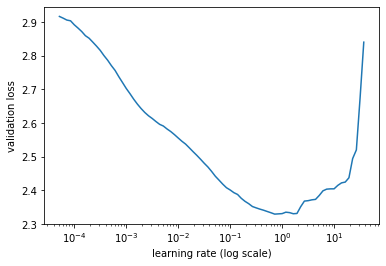

In [13]:
learn.sched.plot(10,1)

In [30]:
learn.fit??

In [14]:
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,13.68,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.10137    2.078196   0.2456    
    1      1.808336   1.75911    0.3313                    
    2      1.605285   1.538725   0.423                     
    3      1.427986   1.32315    0.514                     
    4      1.262607   1.31214    0.5362                    
    5      1.116834   1.041318   0.6275                    
    6      0.983269   1.004707   0.6521                    
    7      0.876814   0.819232   0.7105                    
    8      0.781908   1.225332   0.624                     
    9      0.706611   0.712097   0.7513                    
    10     0.633502   0.783547   0.7369                    
    11     0.582253   0.778135   0.7372                    
    12     0.542453   0.717935   0.7652                    
    13     0.510506   0.771919   0.752                     
    14     0.488338   0.705856   0.7779                    
    15     0.455102   0.734805   0.7621                 

[0.2660628090143204, 0.9349000006675721]

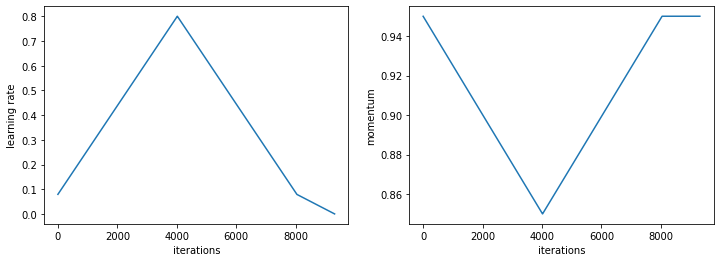

In [15]:
learn.sched.plot_lr()

Text(0, 0.5, 'Accuracy')

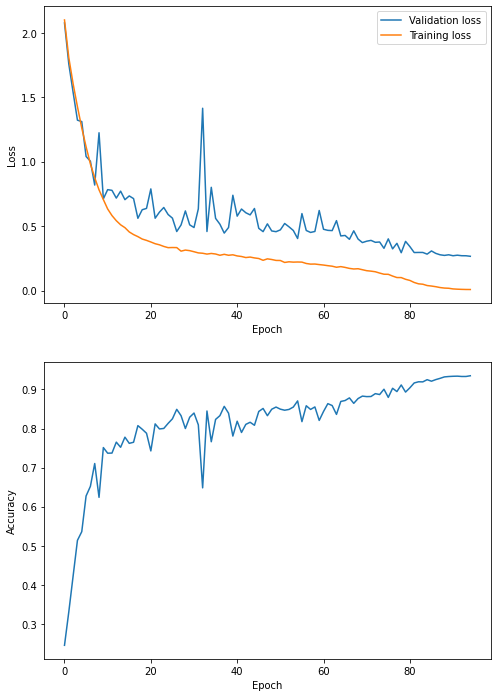

In [16]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

# 2

In [17]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,50,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      1.820838   1.715915   0.3429    
    1      1.581654   1.846301   0.3844                    
    2      1.384071   1.374338   0.5148                    
    3      1.171523   1.236265   0.5598                    
    4      0.993593   0.934098   0.6756                    
    5      0.848229   0.92505    0.6729                    
    6      0.740359   0.949851   0.6897                    
    7      0.652908   0.675708   0.7623                    
    8      0.591278   0.738652   0.7534                    
    9      0.555016   0.703009   0.7632                    
    10     0.524272   0.839355   0.7373                    
    11     0.493805   0.671709   0.7684                    
    12     0.468865   0.841727   0.7202                    
    13     0.446813   0.618257   0.7954                    
    14     0.439444   0.633491   0.7981                    
    15     0.418472   0.511909   0.8245                 

[0.30080496072769164, 0.9318000005722046]

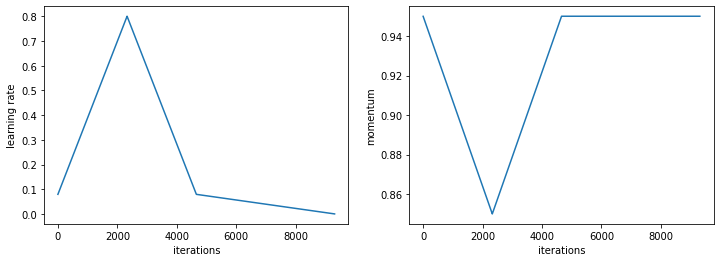

In [28]:
learn.sched.plot_lr()

# 3

In [30]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=50,use_clr_beta=(20,10,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.37709    2.305447   0.1023    
    1      2.310715   2.298782   0.1                       
    2      2.283535   2.277313   0.1176                    
    3      2.17713    2.270912   0.1801                    
    4      1.961593   1.874732   0.2862                    
    5      1.819557   2.099216   0.2256                    
    6      1.723635   1.808534   0.3179                    
    7      1.621008   1.690436   0.3594                    
    8      1.489277   2.433865   0.3214                    
    9      1.321177   3.376488   0.2262                    
    10     1.18305    2.062536   0.4361                    
    11     1.093867   2.878489   0.3331                    
    12     0.999402   1.454207   0.491                     
    13     0.939942   2.044304   0.4758                    
    14     0.868241   1.362805   0.5818                    
    15     0.823      1.082713   0.6423                 

[0.24862593977451325, 0.9203000002861023]

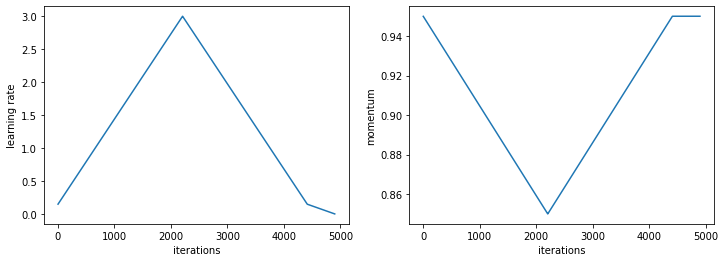

In [31]:
learn.sched.plot_lr()

Text(0, 0.5, 'Accuracy')

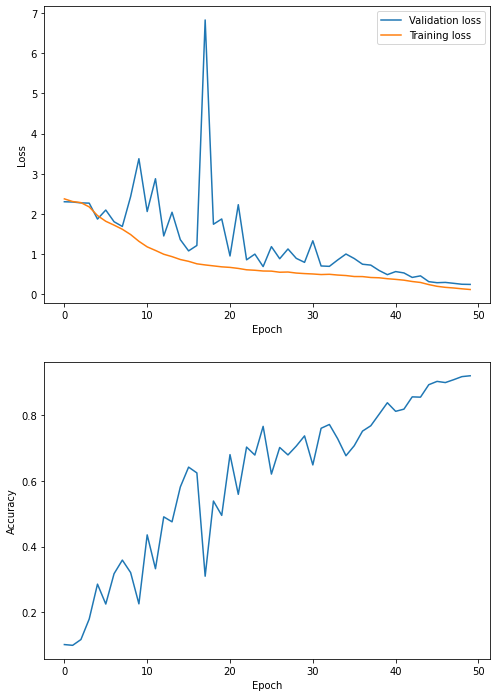

In [32]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(50)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(50)),[learn.sched.losses[i] for i in range(97,50*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(50)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

# Longer

In [33]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=70,use_clr_beta=(20,10,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.384737   2.298445   0.1127    
    1      2.295708   2.280127   0.1193                    
    2      2.173522   2.063813   0.209                     
    3      1.913683   1.815795   0.3093                    
    4      1.732278   1.975662   0.3208                    
    5      1.606271   1.634417   0.3923                    
    6      1.491787   1.57828    0.4211                    
    7      1.387394   1.503333   0.462                     
    8      1.249321   1.493015   0.4991                    
    9      1.12248    2.097247   0.3941                    
    10     1.020013   1.284509   0.5526                    
    11     0.947281   1.851752   0.4453                    
    12     0.872731   1.090911   0.6291                    
    13     0.79844    1.720871   0.4995                    
    14     0.743493   1.787736   0.5252                    
    15     0.71814    1.469683   0.579                  

[0.2516783118247986, 0.9180000005722045]

Text(0, 0.5, 'Accuracy')

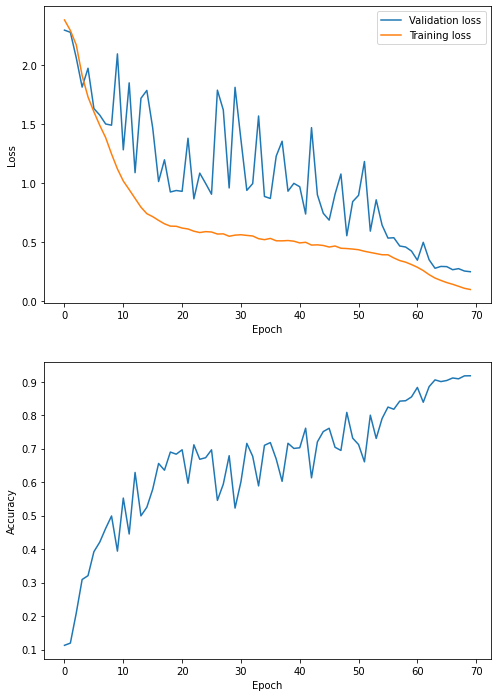

In [34]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(70)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(70)),[learn.sched.losses[i] for i in range(97,70*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(70)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

# Constant momentum

In [35]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,13.68,0.9,0.9),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.054962   1.838241   0.294     
    1      1.722419   1.627838   0.4086                    
    2      1.498073   1.45132    0.4693                    
    3      1.324523   1.377827   0.5008                    
    4      1.135931   1.126484   0.5987                    
    5      0.982698   1.130819   0.5982                    
    6      0.849197   1.09862    0.644                     
    7      0.75481    0.764971   0.7381                    
    8      0.674268   0.697852   0.7629                    
    9      0.623016   0.819851   0.7245                    
    10     0.578604   0.745407   0.7506                    
    11     0.535982   0.838623   0.7375                    
    12     0.505473   0.551068   0.8129                    
    13     0.480194   0.563398   0.8062                    
    14     0.456231   0.515184   0.8285                    
    15     0.447563   0.653588   0.795                  

[0.2743184108376503, 0.9343000008583069]

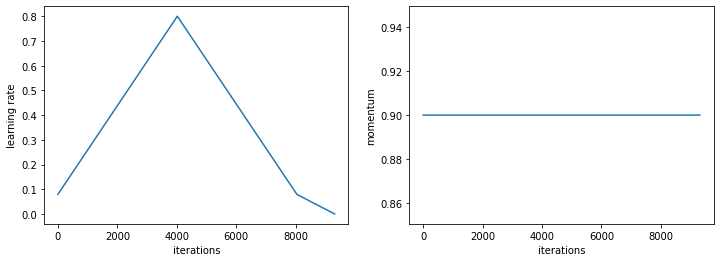

In [36]:

learn.sched.plot_lr()

Text(0, 0.5, 'Accuracy')

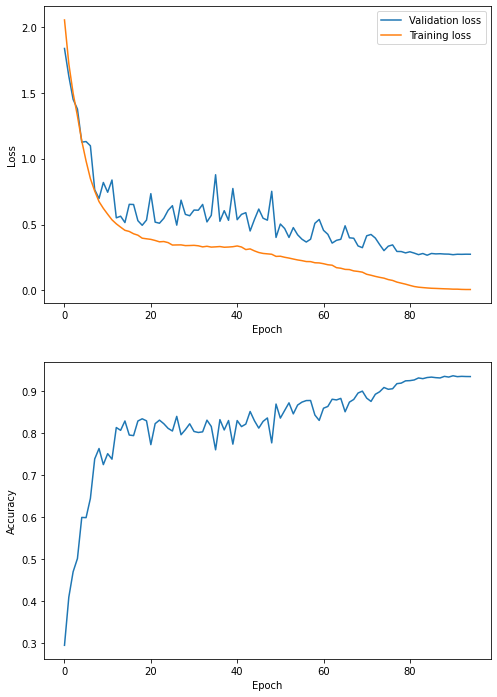

In [37]:

fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

## Higher lr

In [38]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=50,use_clr_beta=(20,10,0.9,0.9),wds=1e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.20959    2.158666   0.1816    
    1      1.864599   1.833235   0.3376                    
    2      1.611475   1.764862   0.3962                    
    3      1.384533   1.276807   0.5328                    
    4      1.2189     1.649231   0.4596                    
    5      1.06199    1.175659   0.5909                    
    6      0.969763   1.312632   0.5526                    
    7      0.880044   1.17105    0.6178                    
    8      0.796831   1.233039   0.5985                    
    9      0.739136   1.359237   0.5636                    
    10     0.704661   1.110043   0.6106                    
    11     0.662266   2.298076   0.4929                    
    12     0.641189   0.900231   0.7113                    
    13     0.628382   1.729993   0.515                     
    14     0.626433   1.309717   0.6406                    
    15     0.608345   0.86566    0.7172                 

[0.2418233198404312, 0.9217000003814697]

## Weight decay tuning

In [20]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-2,start_lr=0.01,end_lr=100,num_it=100)

In [21]:
trn_lossesw2 = learn.sched.losses
val_lossesw2 = learn.sched.val_losses
lrsw2 = learn.sched.lrs

In [22]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-3,start_lr=0.01,end_lr=100,num_it=100)

In [23]:
trn_lossesw3 = learn.sched.losses
val_lossesw3 = learn.sched.val_losses
lrsw3 = learn.sched.lrs

In [24]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-4,start_lr=0.01,end_lr=100,num_it=100)

In [25]:
trn_lossesw4 = learn.sched.losses
val_lossesw4 = learn.sched.val_losses
lrsw4 = learn.sched.lrs

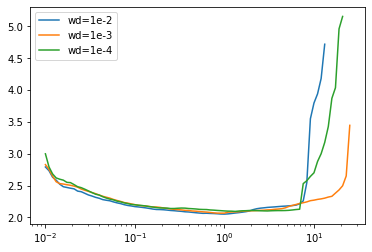

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.set_xscale('log')
ax.legend(loc='upper left')